In [34]:
import io
import itertools

import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins.hparams import api as hp

Downloading and Preprocessing the data

In [2]:
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [35]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [36]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [37]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

In [38]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [39]:
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [40]:
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [41]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [42]:
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [43]:
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

In [44]:
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

Defining hyperparameters

In [45]:
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([3,5,7]))
HP_OPTIMIZER = hp.HParam('optimizer',hp.Discrete(['adam','sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

Creating the Model and Training it

In [53]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(50, hparams[HP_FILTER_SIZE], activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(50, hparams[HP_FILTER_SIZE], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
    ])

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    model.compile(optimizer=hparams[HP_OPTIMIZER], loss=loss_fn, metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0,
        restore_best_weights = True
    )

    model.fit(
        train_data,
        epochs = NUM_EPOCHS,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = validation_data,
        verbose = 2
    )

    # Testing our model
    _, accuracy = model.evaluate(test_data)

    return accuracy

In [54]:
def run(log_dir, hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams) # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

Trainig the model with the different hyperparameters

In [55]:
session_num = 0

for filter_size in HP_FILTER_SIZE.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:

        hparams = {
            HP_FILTER_SIZE: filter_size,
            HP_OPTIMIZER: optimizer
        }
        run_name = "run-%d" % session_num
        print('___ Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)

        session_num += 1

___ Starting trial: run-0
{'filter_size': 3, 'optimizer': 'adam'}
Epoch 1/20


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 9s - 20ms/step - accuracy: 0.9180 - loss: 0.3009 - val_accuracy: 0.9728 - val_loss: 0.0901
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.9754 - loss: 0.0813 - val_accuracy: 0.9818 - val_loss: 0.0591
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 18ms/step - accuracy: 0.9829 - loss: 0.0560 - val_accuracy: 0.9875 - val_loss: 0.0421
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.9854 - loss: 0.0466 - val_accuracy: 0.9850 - val_loss: 0.0477
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.9875 - loss: 0.0388 - val_accuracy: 0.9892 - val_loss: 0.0321
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.9895 - loss: 0.0333 - val_accuracy: 0.9918 - val_loss: 0.0267
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.99

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 20ms/step - accuracy: 0.5949 - loss: 1.5953 - val_accuracy: 0.8513 - val_loss: 0.5469
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 20ms/step - accuracy: 0.8825 - loss: 0.4088 - val_accuracy: 0.9010 - val_loss: 0.3328
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.9109 - loss: 0.3023 - val_accuracy: 0.9108 - val_loss: 0.2998
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.9271 - loss: 0.2484 - val_accuracy: 0.9273 - val_loss: 0.2425
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.9392 - loss: 0.2091 - val_accuracy: 0.9420 - val_loss: 0.1982
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9473 - loss: 0.1808 - val_accuracy: 0.9470 - val_loss: 0.1717
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.95

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 9s - 22ms/step - accuracy: 0.9309 - loss: 0.2464 - val_accuracy: 0.9758 - val_loss: 0.0773
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 20ms/step - accuracy: 0.9809 - loss: 0.0632 - val_accuracy: 0.9863 - val_loss: 0.0522
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
422/422 - 10s - 24ms/step - accuracy: 0.9871 - loss: 0.0424 - val_accuracy: 0.9845 - val_loss: 0.0474
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
422/422 - 12s - 28ms/step - accuracy: 0.9894 - loss: 0.0354 - val_accuracy: 0.9923 - val_loss: 0.0268
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 10s - 24ms/step - accuracy: 0.9915 - loss: 0.0275 - val_accuracy: 0.9927 - val_loss: 0.0222
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 9s - 21ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.9937 - val_loss: 0.0249
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 20ms/step - accuracy: 0

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 11s - 27ms/step - accuracy: 0.7178 - loss: 1.1867 - val_accuracy: 0.8797 - val_loss: 0.4076
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 10s - 23ms/step - accuracy: 0.9022 - loss: 0.3347 - val_accuracy: 0.9173 - val_loss: 0.2880
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 9s - 22ms/step - accuracy: 0.9281 - loss: 0.2466 - val_accuracy: 0.9320 - val_loss: 0.2333
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 20ms/step - accuracy: 0.9413 - loss: 0.1982 - val_accuracy: 0.9445 - val_loss: 0.1837
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.9509 - loss: 0.1684 - val_accuracy: 0.9567 - val_loss: 0.1509
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.9576 - loss: 0.1454 - val_accuracy: 0.9575 - val_loss: 0.1398
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 19ms/step - accuracy: 0.9297 - loss: 0.2408 - val_accuracy: 0.9742 - val_loss: 0.0943
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9786 - loss: 0.0710 - val_accuracy: 0.9843 - val_loss: 0.0558
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 18ms/step - accuracy: 0.9848 - loss: 0.0507 - val_accuracy: 0.9857 - val_loss: 0.0449
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9880 - loss: 0.0389 - val_accuracy: 0.9903 - val_loss: 0.0313
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9899 - loss: 0.0326 - val_accuracy: 0.9918 - val_loss: 0.0241
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 18ms/step - accuracy: 0.9912 - loss: 0.0276 - val_accuracy: 0.9937 - val_loss: 0.0203
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.99

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 8s - 18ms/step - accuracy: 0.7649 - loss: 1.0112 - val_accuracy: 0.8912 - val_loss: 0.3904
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9067 - loss: 0.3243 - val_accuracy: 0.9272 - val_loss: 0.2595
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9288 - loss: 0.2462 - val_accuracy: 0.9305 - val_loss: 0.2270
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9409 - loss: 0.2031 - val_accuracy: 0.9485 - val_loss: 0.1778
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9490 - loss: 0.1734 - val_accuracy: 0.9542 - val_loss: 0.1650
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.9551 - loss: 0.1528 - val_accuracy: 0.9593 - val_loss: 0.1400
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
422/422 - 7s - 17ms/step - accuracy: 0.95

In [14]:
model.summary(line_length = 75)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)   │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_1 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten (Flatten)              │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i,j] > threshold else "black"
        plt.text(j,i, cm[i,j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [19]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and returns it. 
    The supplied figure is closed and inaccessible after this call"""
    
    # Save the plot to a PNG in memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)

    buf.seek(0)

    # Convert PNG to buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    # Add the batch dimension
    image = tf.expand_dims(image, 0)

    return image

In [20]:
# Define a file writer variable for Logging purpose
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)

    # Log the confusion matrix as an image summery
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix",cm_image, step=epoch)

In [21]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

Visualizing in Tensorboard

In [27]:
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Testing Our Model

In [28]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9899 - loss: 0.0323


In [29]:
# Printing the test results
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss, test_accuracy*100))

Test loss:  0.0323. Test accuracy:  98.99%


Ploting Images and the results

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

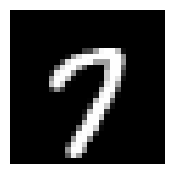

label: 7


In [32]:
# The image to be displayed and tested
i = 5054

# plot the image
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="grey", aspect='auto')
plt.show()

# print the correct label for the image
print("label: {}".format(labels_test[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<BarContainer object of 10 artists>

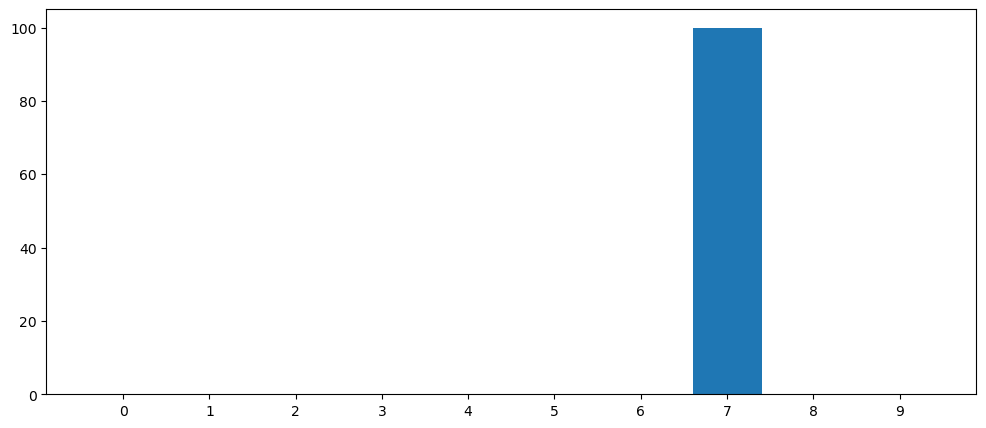

In [33]:
# obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmax activities into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities * 100

# create a bar chart to plot the probabilites for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10],height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])